# Automate Identification And Recognition Of Handwritten Text from An Image.

(Using Convolutional Neural Network)


----------------------------------------------------------------------------------------------------------------------------------------------------------------


**Name Of The Student :** Shaikh Mohammad Yasir Mohammad Danish

**Internship Project Topic :** Automate extraction of handwritten text from an image

**Name of the Organization :** TCS iON

**Name of the Industry Mentor :** Debashish Roy

**Name of the Institute :** BK Birla College of Arts, Science and Commerce



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/Colab Notebooks/automate_extraction_dataset.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall('/content/drive/MyDrive/Colab Notebooks/automate_extraction_dataset')
  print('Done')


Done


In [1]:
# Importing all the necessary libraries needed for Automate extraction of handwritten text from an image

import os # Used for interacting with the operating system, such as navigating directories and file management.
import glob # Useful for file pattern matching and retrieving a list of filenames.
import numpy as np # A fundamental library for numerical computations and array manipulation.
# from matplotlib import image as mpimg
from matplotlib import pyplot as plt # For data visualization
from sklearn.preprocessing import LabelEncoder # Helpful for encoding categorical labels (e.g., writer IDs) as numerical values.
from sklearn.model_selection import train_test_split #  Used to split your data into training and testing sets.
from PIL import Image # Part of the Python Imaging Library (PIL) and widely used for image processing and manipulation.
from random import sample # Randomly selecting samples from your dataset.
from tensorflow.keras.utils import to_categorical # Used for one-hot encoding categorical labels.
from sklearn.utils import shuffle # Shuffling dataset
from tensorflow.image import resize # Resizing the images for pre-processing and feeding to model.
from tensorflow.keras.models import Sequential, load_model # Required for building Sequential ML model and load saved model
from tensorflow.keras import layers # Contains various layers for building neural networks.
from tensorflow.keras.callbacks import ModelCheckpoint # Used for saving the model after every epochs.
import pandas as pd # Useful for data manipulation and analysis, Saving the trained model history as excel file.""

In [2]:
d = {}
from subprocess import check_output
with open('/content/drive/MyDrive/Colab Notebooks/automate_extraction_dataset/forms_for_parsing.txt') as f:
    for line in f:
        key = line.split(' ')[0]
        writer = line.split(' ')[1]
        d[key] = writer
print(len(d.keys()))


1539


In [3]:
temp = []
target_list = []
# Getting the relative path below

# Dataset\\data_subset
path_to_files = os.path.join("/content/drive/MyDrive/Colab Notebooks/automate_extraction_dataset/data_subset/data_subset", "*")
for file_name in sorted(glob.glob(path_to_files)):
    # print(file_name)
    temp.append(file_name)
    image_name = file_name.split("/")[-1] # a01-000u-s00-00.png
    # print(image_name) # # a01-000u-s00-00.png
    file, ext = os.path.splitext(image_name) # Split the extension from a pathname.
    # print(file, ext) # It gives filename, extention
    parts = file.split("-")
    # print(parts) # ['a01', '000u', 's00', '00']
    form = parts[0] + "-" + parts[1]
    # print(form) # a01-000u

    for key in d:
        if key == form:
            target_list.append(str(d[form]))

# print(target_list) # ['000', '000', '000', '000', '000', '000', '000', ...

# print(temp)
img_files = np.array(temp)
img_targets = np.array(target_list)
print(f"Shape of the image files:- {img_files.shape}")
print(f"Shape of the target image files:- {img_targets.shape}")

Shape of the image files:- (4899,)
Shape of the target image files:- (4899,)


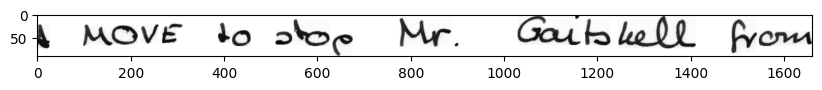

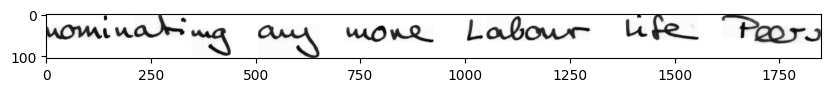

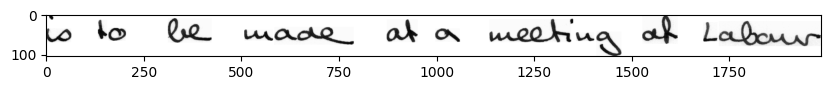

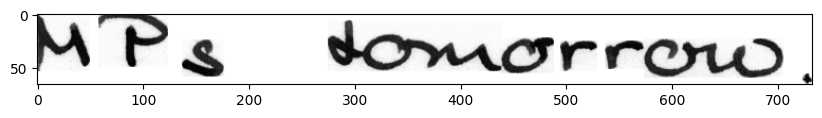

In [4]:
# visualize the image data
for file_name in img_files[:4]:
    img = plt.imread(file_name)
    plt.figure(figsize = (10, 10))
    plt.axis("on") # plt.axis("off")
    plt.imshow(img, cmap = "gray")

In [5]:
# Label Encoding the writer names for one hot encoding later

encoder = LabelEncoder()
encoded_Y = encoder.fit_transform(img_targets)

print(img_files[:1], img_targets[:5], encoded_Y[:5])

['/content/drive/MyDrive/Colab Notebooks/automate_extraction_dataset/data_subset/data_subset/a01-000u-s00-00.png'] ['000' '000' '000' '000' '000'] [0 0 0 0 0]


In [6]:
train_files, rem_files, train_targets, rem_targets = train_test_split(img_files, encoded_Y, train_size = 0.66, random_state = 52, shuffle = True)

validation_files, test_files, validation_targets, test_targets = train_test_split(rem_files, rem_targets, train_size = 0.5, random_state = 24, shuffle = True)

print("#" * 20)
print(f"Train files shape:- {train_files.shape}")
print(f"Validation files shape:- {validation_files.shape}")
print(f"Test files shape:- {test_files.shape}")

print("#" * 20)
print(f"Train targets shape:- {train_targets.shape}")
print(f"Validation targets shape:- {validation_targets.shape}")
print(f"Test targets shape:- {test_targets.shape}")


####################
Train files shape:- (3233,)
Validation files shape:- (833,)
Test files shape:- (833,)
####################
Train targets shape:- (3233,)
Validation targets shape:- (833,)
Test targets shape:- (833,)


In [7]:
batch_size = 16
num_classes = 50 # Number of writers are 50.

def generate_data(samples, target_files, batch_size = batch_size, factor = 0.1):
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset : offset + batch_size]
            batch_targets = target_files[offset : offset + batch_size]

            images = []
            targets = []

            for i in range(len(batch_samples)):
                batch_sample = batch_samples[i]
                batch_target = batch_targets[i]
                im = Image.open(batch_sample)
                cur_width = im.size[0]
                cur_height = im.size[1]

                # print(cur_width, cur_height)
                height_fac = 113 / cur_height

                new_width = int(cur_width * height_fac)
                size = new_width, 113

                # # PIL.Image.Resampling.LANCZOS
                imresize = im.resize((size), Image.LANCZOS) ## Resize so height = 113 while keeping aspect ratio
                now_width = imresize.size[0]
                now_height = imresize.size[1]
                # Generate crops of size 113x113 from this resized image and keep random 10% of crops

                # total x start points are from 0 to width -113
                avail_x_points = list(range(0, now_width - 113))

                # Pick random x%
                pick_num = int(len(avail_x_points) * factor)

                # Now pick
                random_startx = sample(avail_x_points, pick_num)

                for start in random_startx:
                    imcrop = imresize.crop((start, 0, start + 113, 113))
                    images.append(np.asarray(imcrop))
                    targets.append(batch_target)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(targets)

            # reshaping X_train for feeding in later
            X_train = X_train.reshape(X_train.shape[0], 113, 113, 1)
            #convert to float and normalize
            X_train = X_train.astype("float32")
            X_train = X_train / 255 # Normalizing

            # One hot encode y
            y_train = to_categorical(y_train, num_classes)

            yield shuffle(X_train, y_train)

In [8]:
# Generate train, test and validation data

train_generator = generate_data(train_files, train_targets, batch_size = batch_size, factor = 0.3)
validation_generator = generate_data(validation_files, validation_targets, batch_size = batch_size, factor = 0.3)
test_generator = generate_data(test_files, test_targets, batch_size = batch_size, factor = 0.1)

In [9]:
def resize_image(image):
    return resize(image, [56, 56])

row, col, ch = 113, 113, 1 # Rows, columns, channels

model = Sequential(
    [
        layers.ZeroPadding2D(padding = (1, 1), input_shape = (row, col, ch)),

        # Resizing the data within the neural network.
        layers.Lambda(resize_image, name = "Image_resize"), # resizing of the images allows easy computation.

        # CNN Model
        layers.Convolution2D(filters = 32, kernel_size = (5, 5), strides = (2, 2), padding = "same", name = "conv1"),
        layers.Activation(activation = "relu"),
        layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid", name = "pool1"),

        layers.Convolution2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = "same", name = "conv2"),
        layers.Activation(activation = "relu"),
        layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2), name = "pool2"),

        layers.Convolution2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding = "same", name = "conv3"),
        layers.Activation(activation = "relu"),
        layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid", name = "pool3"),

        layers.Flatten(),
        layers.Dropout(rate = 0.5),

        layers.Dense(units = 256, name = "dense1"),
        layers.Activation(activation = "relu"),
        layers.Dropout(rate = 0.5),

        layers.Dense(units = 256, name = "dense2"),
        layers.Activation(activation = "relu"),
        layers.Dropout(rate = 0.5),

        layers.Dense(units = num_classes, name = "output"),
        layers.Activation(activation = "softmax"), # Using Softmax activation since output is within 50 classes.
    ]
)

model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPaddin  (None, 115, 115, 1)       0         
 g2D)                                                            
                                                                 
 Image_resize (Lambda)       (None, 56, 56, 1)         0         
                                                                 
 conv1 (Conv2D)              (None, 28, 28, 32)        832       
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 14, 14, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 14, 14, 64)        18496     
                                                        

In [10]:
checkpoint_directory = '/content/sample_data/my_model'

# Create the directory if it doesn't exist
if not os.path.exists(checkpoint_directory):
    os.makedirs(checkpoint_directory)

In [11]:
epochs = 2
steps_per_epoch = 800
validation_steps = 200

from keras.callbacks import ModelCheckpoint

# Saving every model using tensorflow.keras checkpoint
filepath = "/content/sample_data/my_model/model-{epoch:02d}-{val_loss:.4f}.hdf5" # Use .keras to remove warning
checkpoint = ModelCheckpoint(filepath = filepath, verbose = 1, save_best_only = False)
callbacks_list = [checkpoint]

# fit_generator() is depricated therefore fit() will work

history_object = model.fit(train_generator, steps_per_epoch = steps_per_epoch,
                           validation_data = validation_generator,
                           validation_steps = validation_steps, epochs = epochs,
                           verbose = 1, callbacks = callbacks_list)

Epoch 1/2
800/800 [==============================] - ETA: 0s - loss: 2.8509 - accuracy: 0.2677
Epoch 1: saving model to /content/sample_data/my_model/model-01-1.9210.hdf5
800/800 [==============================] - 1393s 2s/step - loss: 2.8509 - accuracy: 0.2677 - val_loss: 1.9210 - val_accuracy: 0.4402
Epoch 2/2


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


800/800 [==============================] - ETA: 0s - loss: 1.8597 - accuracy: 0.4422
Epoch 2: saving model to /content/sample_data/my_model/model-02-1.2852.hdf5
800/800 [==============================] - 986s 1s/step - loss: 1.8597 - accuracy: 0.4422 - val_loss: 1.2852 - val_accuracy: 0.6026


In [12]:

history_dict = {
    'epoch': list(range(1, len(history_object.history['loss']) + 1)),
    'loss': history_object.history['loss'],
    'accuracy': history_object.history['accuracy'],
    'val_loss': history_object.history['val_loss'],
    'val_accuracy': history_object.history['val_accuracy']
}
history_df = pd.DataFrame(history_dict)
excel_file_path = 'training_history.xlsx'  # Replace with your desired file path
history_df.to_excel(excel_file_path, index=False)

In [13]:
model.save("model.hdf5")
print("Whole model is saved successfully")

Whole model is saved successfully


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
loaded_model = load_model("model.hdf5")
print("Whole model loaded successfully")
print(loaded_model.summary())

Whole model loaded successfully
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPaddin  (None, 115, 115, 1)       0         
 g2D)                                                            
                                                                 
 Image_resize (Lambda)       (None, 56, 56, 1)         0         
                                                                 
 conv1 (Conv2D)              (None, 28, 28, 32)        832       
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 14, 14, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 14, 14, 64)        18496     
                        

I took only 2 epochs because this notebook was taking around 40 minutes per epoch, because of less epoch this model have given less accuracy.

In [15]:
scores = loaded_model.evaluate_generator(test_generator , 280) # 842
print(scores)
print(f"Model loss:- {scores[0]}")
print(f"Model Accuracy:- {scores[1]}")

<ipython-input-15-0d35498707e7>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = loaded_model.evaluate_generator(test_generator , 280) # 842


[1.3739550113677979, 0.5742472410202026]
Model loss:- 1.3739550113677979
Model Accuracy:- 0.5742472410202026


In [16]:
images = []

for filename in test_files[:50]:
    im = Image.open(filename)
    cur_width = im.size[0]
    cur_height = im.size[1]

    # print(cur_width, cur_height)

    height_fac = 113 / cur_height

    new_width = int(cur_width * height_fac)
    size = new_width, 113

    imresize = im.resize((size), Image.LANCZOS) # Resizing so height = 113 while keeping aspect ratio
    now_width = imresize.size[0]
    now_height = imresize.size[1]
    # Generating crops of size 113 x 113 from this resized image and keep random 10% of crops

    # Total x start points are from 0 to width -113
    avail_x_points = list(range(0, now_width - 113))

    # Pick random x%
    factor = 0.1
    pick_num = int(len(avail_x_points) * factor)

    random_startx = sample(avail_x_points, pick_num)

    for start in random_startx:
        imcrop = imresize.crop((start, 0, start + 113, 113))
        images.append(np.asarray(imcrop))

    X_test = np.array(images)

    X_test = X_test.reshape(X_test.shape[0], 113, 113, 1)
    # Convet to float and normalize
    X_test = X_test.astype("float32")
    X_test /= 255
    shuffle(X_test)


print(X_test.shape)


(5873, 113, 113, 1)


In [17]:
predictions = loaded_model.predict(X_test, verbose = 1)

print(predictions)
print(predictions.shape)

predicted_writer = []

for pred in predictions:
    predicted_writer.append(np.argmax(pred))

# print(predicted_writer)
print(len(predicted_writer))


184/184 [==============================] - 1s 5ms/step
[[1.0986561e-05 3.8857272e-13 4.3778131e-03 ... 9.1955871e-10
  1.6297883e-09 2.5727281e-12]
 [2.0792820e-02 7.6075807e-08 3.4036320e-02 ... 3.3857206e-05
  1.4656215e-04 2.3807245e-06]
 [1.7756768e-01 4.8334834e-09 5.2543636e-03 ... 2.2094127e-05
  8.3785868e-05 2.3753933e-05]
 ...
 [6.5304677e-09 5.5306825e-11 1.4211648e-02 ... 3.4050792e-08
  4.1064937e-05 9.1839043e-11]
 [2.5097752e-06 3.4187264e-07 2.4329737e-02 ... 1.4003050e-05
  6.3089310e-04 1.5705524e-07]
 [8.3768623e-07 1.8487849e-06 2.4735853e-02 ... 4.9756574e-05
  4.9892333e-03 3.9782182e-07]]
(5873, 50)
5873


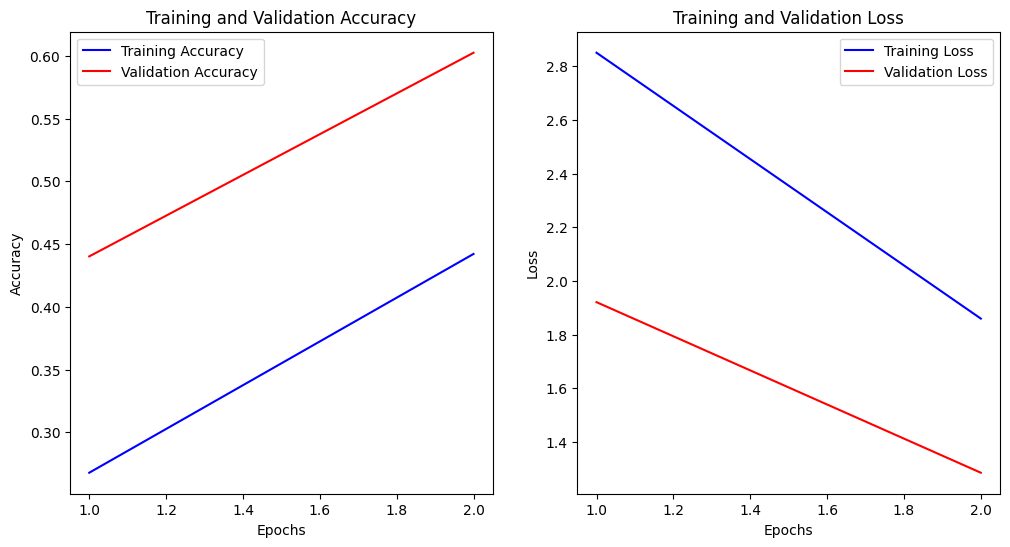

In [18]:
acc = history_object.history["accuracy"]
val_acc = history_object.history["val_accuracy"]
loss = history_object.history["loss"]
val_loss = history_object.history["val_loss"]
epochs = range(1, len(loss) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, "b", label="Training Accuracy")
plt.plot(epochs, val_acc, "r", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "b", label="Training Loss")
plt.plot(epochs, val_loss, "r", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()


<ipython-input-24-737a45597dd4>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(2,2))


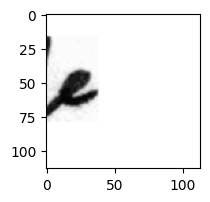

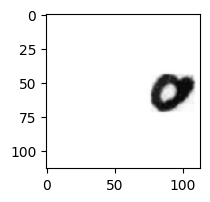

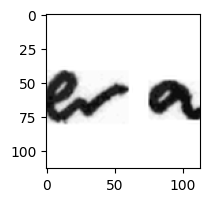

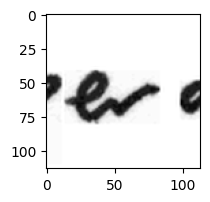

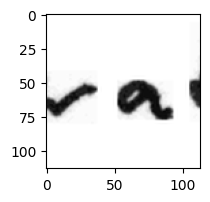

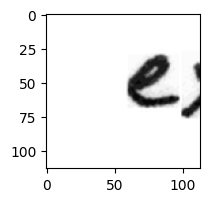

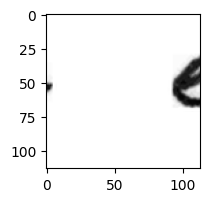

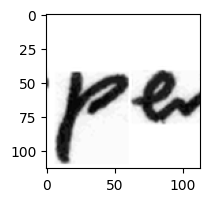

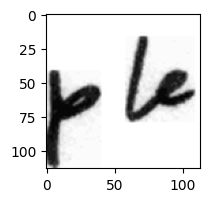

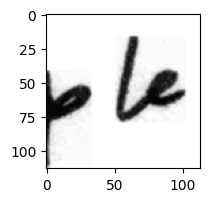

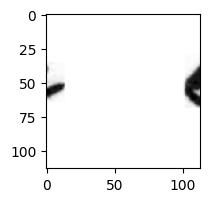

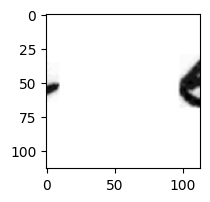

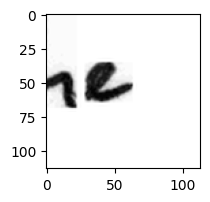

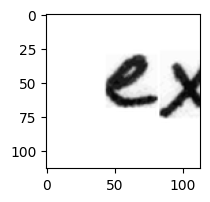

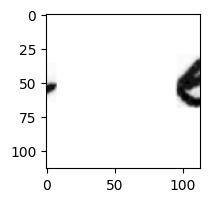

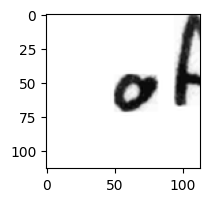

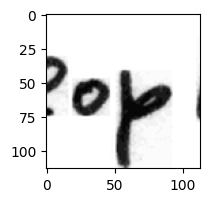

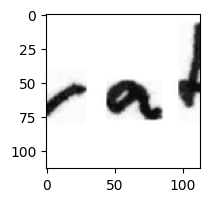

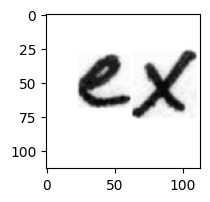

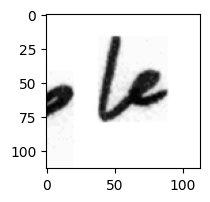

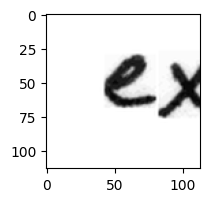

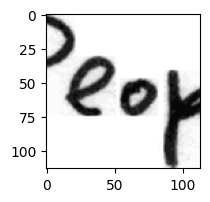

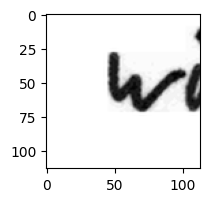

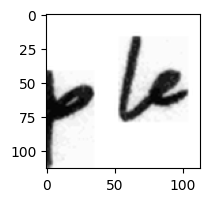

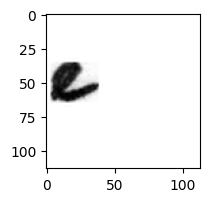

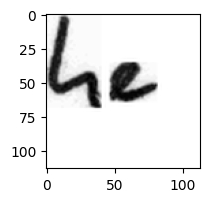

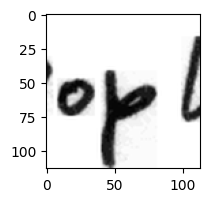

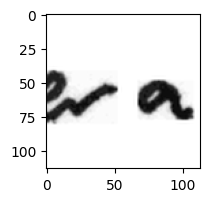

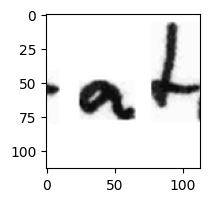

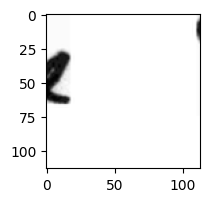

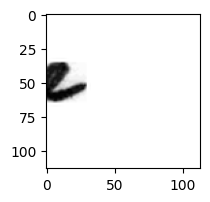

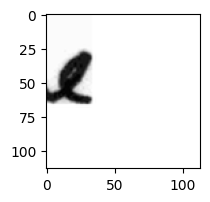

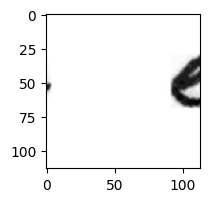

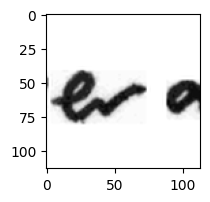

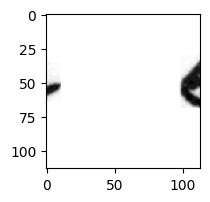

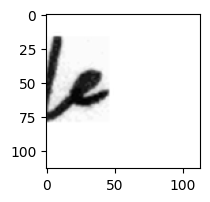

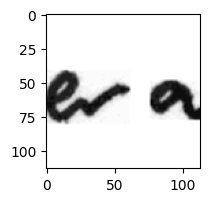

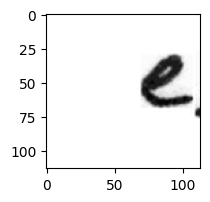

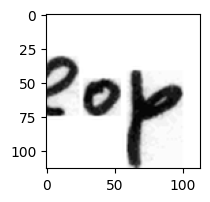

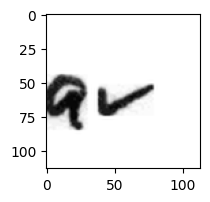

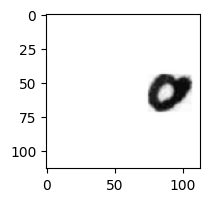

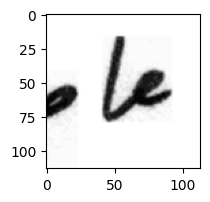

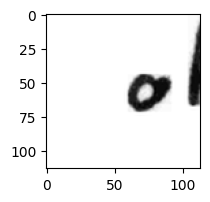

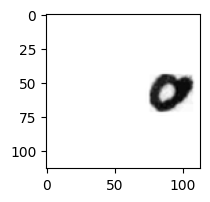

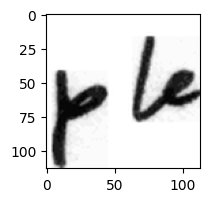

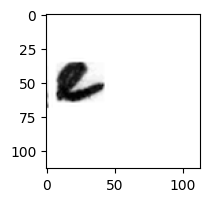

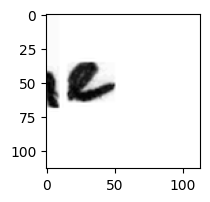

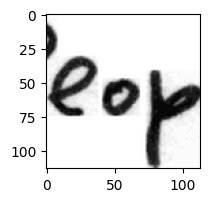

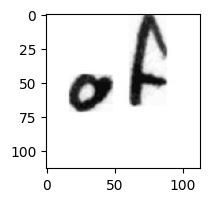

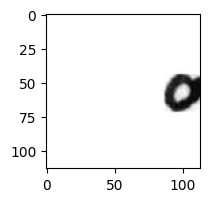

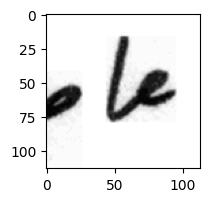

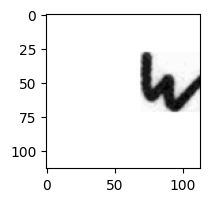

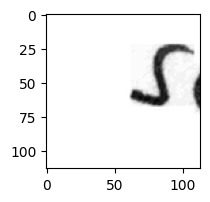

In [24]:

writer_number = 18
total_images =10
counter = 0
for i in range(len(predicted_writer)//10):
     if predicted_writer[i] == writer_number:
         image = X_test[i].squeeze()
         plt.figure(figsize=(2,2))
         plt.imshow(image, cmap ='gray')
image = X_test[18].squeeze()
plt.figure(figsize=(2,2))
plt.imshow(image, cmap ='gray')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 874.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 69.0 MB/s eta 0:00:00
